In [80]:
# Unzip data in Google Colab.
# !unzip members.csv.zip
# !unzip songs.csv.zip
# !unzip test.csv.zip
# !unzip train.csv.zip
# !unzip song_extra_info.csv.zip

# !pip install catboost
# !pip install shap

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoost
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from copy import copy
import shap

In [82]:
%%time
train_types = {
    'msno'               : 'category',
    'source_system_tab'  : 'str',
    'source_screen_name' : 'str',
    'source_type'        : 'str',
    'target'             : np.uint8,
    'song_id'            : 'category'
}

test_types = {
    'msno'               : 'category',
    'source_system_tab'  : 'str',
    'source_screen_name' : 'str',
    'source_type'        : 'str',
    'song_id'            : 'category'
}

songs_types = {
    'genre_ids'   : 'str',
    'language'    : np.float32,
    'artist_name' : 'str',
    'composer'    : 'category',
    'lyricist'    : 'category',
    'song_id'     : 'category'
}

members_types = { 
    'city'           : np.uint8,
    'bd'             : np.int16,
    'gender'         : 'category',
    'registered_via' : np.uint8
}

train   = pd.read_csv('data/train.csv',   dtype=train_types)
test    = pd.read_csv('data/test.csv',    dtype=test_types)
songs   = pd.read_csv('data/songs.csv',   dtype=songs_types)
members = pd.read_csv('data/members.csv', dtype=members_types, 
                       parse_dates=['registration_init_time', 'expiration_date']
                     )
songs_extra = pd.read_csv('data/song_extra_info.csv')

CPU times: user 43.5 s, sys: 5.27 s, total: 48.7 s
Wall time: 54 s


#### Типы фичей, для train, test, songs, members




In [83]:
curve_sep = '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n'
print(train.dtypes, members.dtypes, songs.dtypes, songs_extra.dtypes, sep=curve_sep)

msno                  category
song_id               category
source_system_tab       object
source_screen_name      object
source_type             object
target                   uint8
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
msno                              object
city                               uint8
bd                                 int16
gender                          category
registered_via                     uint8
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
song_id        category
song_length       int64
genre_ids        object
artist_name      object
composer       category
lyricist       category
language        float32
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
song_id    object
name       object
isrc       object
dtype: object


Columns renaming:

In [84]:
train.rename(columns={'msno' : 'user_id'}, inplace=True)
test.rename(columns={'msno' : 'user_id'}, inplace=True)
members.rename(columns={'msno': 'user_id', 'registration_init_time' : 'registration_date'}, inplace=True)

### Анализ признаков пользователей:

In [85]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            34403 non-null  object        
 1   city               34403 non-null  uint8         
 2   bd                 34403 non-null  int16         
 3   gender             14501 non-null  category      
 4   registered_via     34403 non-null  uint8         
 5   registration_date  34403 non-null  datetime64[ns]
 6   expiration_date    34403 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), int16(1), object(1), uint8(2)
memory usage: 974.4+ KB


In [86]:
def merge(df, name):
    """
    Returns new train_, test_, 
    which represents result of merging an input df with train and test, by specified column name.
    """
    train_ = train.merge(df, on=name, how='left')
    test_  = test.merge (df, on=name, how='left')
    return train_, test_

***Сделаем новые фичи для дат:***

1) Год регистрации
2) Месяц регистрации
3) День регистрации
4) Год окончания подписки
5) Месяц окончания подписки
6) Денб окончания подписки
4) Длину подписки, которую потом можно категоризовать.

In [87]:
members['registration_year']  = members['registration_date'].dt.year
members['registration_month'] = members['registration_date'].dt.month
members['registration_day']   = members['registration_date'].dt.day
members['expiration_year']    = members['expiration_date'].dt.year
members['expiration_month']   = members['expiration_date'].dt.month
members['expiration_day']     = members['expiration_date'].dt.day

members['subscription_length'] = members['expiration_date'] - members['registration_date']

members.head()

,user_id,city,bd,gender,registered_via,registration_date,expiration_date,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,subscription_length
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20,2011,8,20,2017,9,20,2223 days
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22,2015,6,28,2017,6,22,725 days
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12,2016,4,11,2017,7,12,457 days
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07,2015,9,6,2015,9,7,1 days
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13,2017,1,26,2017,6,13,138 days


Посмотрим на распределение количества дней подписки:

In [88]:
members['subscription_length'] = members.subscription_length   \
           .apply(lambda days: days / np.timedelta64(1, 'D'))  \
           .astype(np.int32)

<AxesSubplot:ylabel='Frequency'>

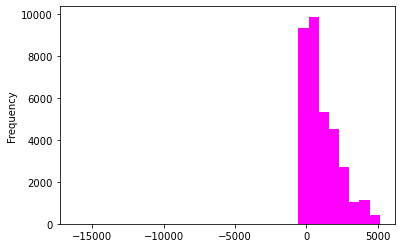

In [89]:
members.subscription_length.plot.hist(color='magenta', bins=30)

# У нас есть выброс посмотрим на него:

In [90]:
members[members.subscription_length < 0]

,user_id,city,bd,gender,registered_via,registration_date,expiration_date,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,subscription_length
16867,1Y+bNz3FxSoJnKOcR/Q8VJGXZbWIstrW0HfBe5LZzKA=,1,0,NaN,9,2014-05-01,1970-01-01,2014,5,1,1970,1,1,-16191


Поставим длинну подписки этому юзеру равную 0

In [91]:
members.loc[16867, 'subscription_length'] = 0

<AxesSubplot:ylabel='Frequency'>

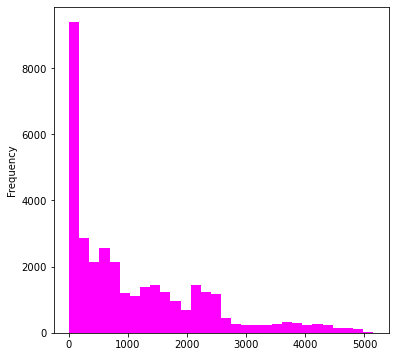

In [92]:
members['subscription_length'].plot.hist(color='magenta', figsize=(6, 6), bins=30)

Категоризуем длинну подписки

counts: 
0     9699
1     3459
3     3100
2     2333
6     1652
7     1597
4     1498
11    1422
10    1380
8     1330
12    1298
5     1292
9     1000
13     455
18     377
19     345
21     326
17     296
14     291
15     273
16     266
20     259
22     171
23     162
24     104
25      18
Name: subscription_length, dtype: int64 
max_days membership: 5149


<AxesSubplot:ylabel='Frequency'>

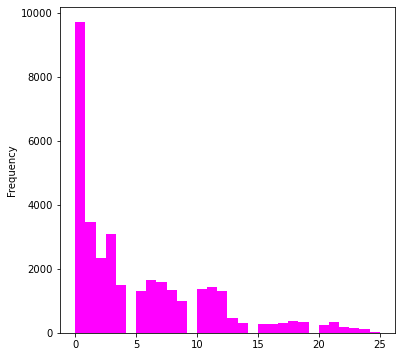

In [93]:
def categorize_subscription(subscription, k=200):
    return subscription.apply(lambda days: days // k)

subscription_level = categorize_subscription(members.subscription_length, k=200)

print('counts: \n{} \nmax_days membership: {}'
      .format(subscription_level.value_counts(), members.subscription_length.max()))

members['subscription_level'] = subscription_level
subscription_level.plot.hist(color='magenta', figsize=(6, 6), bins=30)

In [94]:
def plot_bar(frame, index_name):
    '''
    Counts unique values, and makes a bar plot with counted values.
    
    return: (column, bar_plot)
    '''
    column      = frame[index_name].value_counts()
    column      = pd.DataFrame({ index_name : column.index, 'count' : column.values })
    column['%'] = column['count'].apply(lambda x: x * 100 / column['count'].sum())
    column      = column.sort_values(by=[index_name], ignore_index=True)
    bar = column.plot.bar(color='magenta', figsize=(5, 5), x=index_name, y='%')
    return column, bar

### Анализ категориальный признаков пользователей: 


**Посмотрим на распределение городов:**

<AxesSubplot:xlabel='city'>

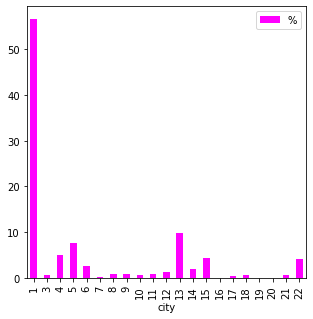

In [95]:
city_count, bar = plot_bar(frame=members, index_name='city')
bar

Теперь зная распределение городов можно сделать разделение на **city_index==1, и city_index != 1**

In [96]:
def update_city_index(city_index):
    if city_index == 1:
        return 1
    else:
        return 0

# Проверял -- работает хуже.
# members['city'] = members['city'].apply(update_index)

**Посмотрим на распределение методов регистрации:**

<AxesSubplot:xlabel='registered_via'>

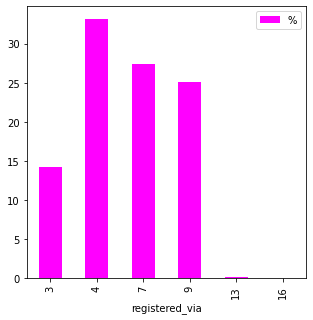

In [97]:
registered_count, bar = plot_bar(frame=members, index_name='registered_via')
bar

In [98]:
registered_count

,registered_via,count,%
0,3,4879,14.181903
1,4,11392,33.113391
2,7,9433,27.419120
3,9,8628,25.079208
4,13,70,0.203471
5,16,1,0.002907


Отнесем выбросы для **registred_via=[16, 13]** к наиболее популярному методу регистрации **(4)**

In [99]:
def update_registration_method(registration_method):
    # 4 is the most popular registration method.
    if registration_method not in [3, 4, 7, 9]:
        return 4
    else:
        return registration_method

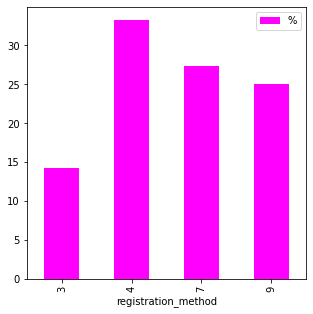

In [100]:
members['registration_method'] = members['registered_via'].apply(update_registration_method) 

_, bar = plot_bar(members, index_name='registration_method')

**Посмотрим на распределение пола пользователей**

male      7405
female    7096
Name: gender, dtype: int64 | nulls: 19902


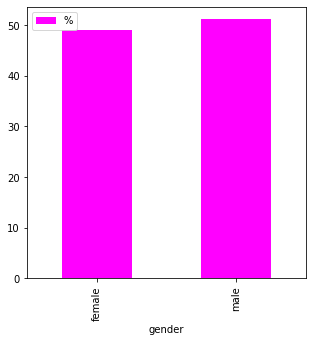

In [101]:
gender_count, bar = plot_bar(frame=members, index_name='gender')
print('{} | nulls: {}'.format(members['gender'].value_counts(), members['gender'].isnull().sum()))

**Удалим ненужные признаки:**

In [102]:
members = members.drop(
    ['gender', 'registered_via', 'expiration_date', 'registration_date'], 
    axis=1
)

members.head()

,user_id,city,bd,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,subscription_length,subscription_level,registration_method
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,2011,8,20,2017,9,20,2223,11,7
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,2015,6,28,2017,6,22,725,3,7
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,2016,4,11,2017,7,12,457,2,4
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,2015,9,6,2015,9,7,1,0,9
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,2017,1,26,2017,6,13,138,0,4


### Замерджим пользователей к train и test:

In [103]:
train, test = merge(members, 'user_id')
del members

In [104]:
train.isnull().sum()

user_id                     0
song_id                     0
source_system_tab       24849
source_screen_name     414804
source_type             21539
target                      0
city                        0
bd                          0
registration_year           0
registration_month          0
registration_day            0
expiration_year             0
expiration_month            0
expiration_day              0
subscription_length         0
subscription_level          0
registration_method         0
dtype: int64

### Анализ признаков для песен: 

In [105]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


   language    count          %
0      -1.0   639467  27.847481
1       3.0   106295   4.628930
2      10.0    15482   0.674209
3      17.0    92518   4.028970
4      24.0    41744   1.817866
5      31.0    39201   1.707123
6      38.0     2385   0.103862
7      45.0    14435   0.628615
8      52.0  1336694  58.210292
9      59.0     8098   0.352651


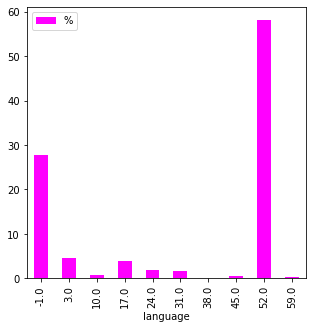

In [106]:
language_count, bar = plot_bar(frame=songs, index_name='language')
print(language_count)

In [107]:
most_popular_language = int(language_count.max()['language'])

# Заполним пропуски наиболее популярным языком и прибавим 2, чтобы в дальшнейшем CatBoost не ругался.
songs['language'] = (songs['language']
                     .fillna(most_popular_language)
                     .astype(np.int8) + 2
                    )

most_popular_language

59

Посмотрим на композиторов, артистов и лиричность

In [108]:
lyricist = songs['lyricist']
composer = songs['composer']
artists  = songs['artist_name']

print('Lyricist nan: {} | Composer nan: {} | Artist nan: {}'
      .format(lyricist.isnull().sum(), composer.isnull().sum(), artists.isnull().sum()))

Lyricist nan: 1945268 | Composer nan: 1071354 | Artist nan: 0


Удалим строку с composer и lyricist, так как они содержат очень много nan-values.

In [109]:
songs = songs.drop(['lyricist', 'composer'], axis=1)
songs.head()

,song_id,song_length,genre_ids,artist_name,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),5
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,33
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,33
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,5
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,54


**Посмотрим на признак отвечающий за длину песен:**

<AxesSubplot:ylabel='Frequency'>

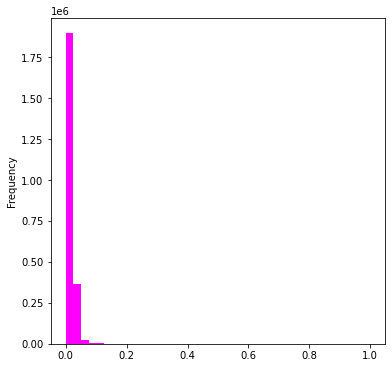

In [110]:
max_length = songs['song_length'].max()
min_length = songs['song_length'].min()

normalized_length = songs['song_length'] / max_length
normalized_length.plot.hist(figsize=(6, 6), bins=40, color='magenta')

Выброшено 22110 песен с большой длинной


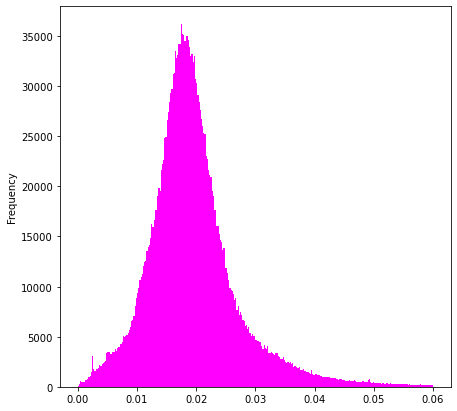

In [111]:
mask = normalized_length < 0.06
normalized_length = normalized_length[mask]
print('Выброшено {} песен с большой длинной'
  .format(songs.shape[0] - normalized_length.shape[0]))

# Можно заметить что практически все песни остались => можно выбросить аутлайеры
normalized_length.plot.hist(color='magenta', figsize=(7, 7), bins=300)

songs = songs[mask]
songs['song_length'] = songs.song_length.astype(np.float32)

mean_song_length = songs['song_length'].mean()

In [112]:
songs['song_length'] = songs['song_length'].fillna(mean_song_length)

**Обработаем жанры песен:**

In [ ]:
genres_counter = defaultdict(int)

def fill_counter(genres):
    for genre in genres.split('|'):
        genres_counter[genre] += 1
    
    return genres

Заполним наш словарь с жанрами:

In [114]:
songs['genre_ids'] = songs['genre_ids'].dropna().apply(fill_counter)

**Заполняем пропуски наиболее популярным жанром**

In [115]:
most_popular_genre = max(genres_counter, key=lambda k: genres_counter[k])

songs['genre_ids'] = songs['genre_ids'].fillna(most_popular_genre)

In [116]:
def save_one_genre(genres):
    counts_genre = [(genres_counter[genre], genre) for genre in genres.split('|')]
    c, g = max(counts_genre)
    return g

In [117]:
songs['genre_ids'] = songs['genre_ids'].apply(save_one_genre)
len(songs['genre_ids'].unique())

174

Обработаем артистов

In [118]:
artists = songs['artist_name'].value_counts()
artists = pd.DataFrame({ 'artist_name' : artists.index, 'count' : artists.values })

most_popular_artist = artists.max()['artist_name']
most_popular_artist

'｢冬のソナタ｣ オルゴールサウンドコレクション'

In [119]:
train, test = merge(songs, 'song_id')
del songs
train.isnull().sum()

user_id                     0
song_id                     0
source_system_tab       24849
source_screen_name     414804
source_type             21539
target                      0
city                        0
bd                          0
registration_year           0
registration_month          0
registration_day            0
expiration_year             0
expiration_month            0
expiration_day              0
subscription_length         0
subscription_level          0
registration_method         0
song_length              9251
genre_ids                9251
artist_name              9251
language                 9251
dtype: int64

### Анализ Song Extra Info:

In [120]:
songs_extra.head(), songs_extra.dtypes

(                                        song_id             name          isrc
 0  LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=               我們  TWUM71200043
 1  ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=  Let Me Love You  QMZSY1600015
 2  u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=              原諒我  TWA530887303
 3  92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=          Classic  USSM11301446
 4  0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=             愛投羅網  TWA471306001,
 song_id    object
 name       object
 isrc       object
 dtype: object)

[Что такое ISRC?](https://www.ppluk.com/membership/more-information/isrc/)

In [121]:
def isrc_to_year(isrc):
    year = int(isrc[5:7])
    if year > 17:
        return 1900 + year
    else:
        return 2000 + year

def isrc_to_country_code(isrc):
    return isrc[:2]

def isrc_to_reg_code(isrc):
    return isrc[7:]

In [122]:
songs_na = pd.DataFrame({ 'isrc' : songs_extra['isrc'].dropna().astype(str) })
songs_na.shape, songs_extra.shape

((2159423, 1), (2295971, 3))

In [123]:
songs_na['year']         = songs_na.isrc.apply(isrc_to_year)
songs_na['country_code'] = songs_na.isrc.apply(isrc_to_country_code)
songs_na['reg_org']      = songs_na.isrc.apply(isrc_to_reg_code)

print('''
years:         
{}

country codes: 
{}

reg codes:    
{}
      '''
      .format(songs_na.year.value_counts(), 
              songs_na.country_code.value_counts(),
              songs_na.reg_org.value_counts()))

most_common_year = 15
most_common_country_code = 'US'
most_common_reg_code = '00001'


years:         
2015    268266
2016    254342
2014    211560
2013    136376
2012    130063
         ...  
1945        86
1944        79
1928        78
1943        70
1948        38
Name: year, Length: 100, dtype: int64

country codes: 
US    651830
GB    310782
DE    194045
FR    148459
TC    104693
       ...  
GA         1
BK         1
AC         1
HL         1
IX         1
Name: country_code, Length: 200, dtype: int64

reg codes:    
00001    11162
00002     8854
00003     7843
00004     7300
00005     7015
         ...  
29656        1
99797        1
73383        1
79892        1
79166        1
Name: reg_org, Length: 99806, dtype: int64
      


In [124]:
isrc_nulls = songs_extra['isrc'].isnull()

songs_extra['song_registration_year'] = most_common_year
songs_extra['song_registration_year'] = songs_extra.song_registration_year.astype(np.uint8)
songs_extra['song_country_code'] = most_common_country_code
songs_extra['song_registration_organisation'] = most_common_reg_code

In [125]:
def apply_transform(name, func):
    mask = ~isrc_nulls
    songs_extra.loc[mask, name] = songs_extra.loc[mask, 'isrc'].apply(func)

apply_transform('song_registration_year', isrc_to_year)
apply_transform('song_country_code', isrc_to_country_code)
apply_transform('song_registration_organisation', isrc_to_reg_code)

songs_extra.head()

,song_id,name,isrc,song_registration_year,song_country_code,song_registration_organisation
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043,2012,TW,00043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015,2016,QM,00015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303,2008,TW,87303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446,2013,US,01446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001,2013,TW,06001


In [126]:
songs_extra = songs_extra.drop(['isrc', 'name'], axis=1)
train, test = merge(songs_extra, 'song_id')

del songs_extra

train.isnull().sum()

user_id                                0
song_id                                0
source_system_tab                  24849
source_screen_name                414804
source_type                        21539
target                                 0
city                                   0
bd                                     0
registration_year                      0
registration_month                     0
registration_day                       0
expiration_year                        0
expiration_month                       0
expiration_day                         0
subscription_length                    0
subscription_level                     0
registration_method                    0
song_length                         9251
genre_ids                           9251
artist_name                         9251
language                            9251
song_registration_year              1455
song_country_code                   1455
song_registration_organisation      1455
dtype: int64

### Обработка train dataset:

In [127]:
train.dtypes

user_id                            object
song_id                            object
source_system_tab                  object
source_screen_name                 object
source_type                        object
target                              uint8
city                                uint8
bd                                  int16
registration_year                   int64
registration_month                  int64
registration_day                    int64
expiration_year                     int64
expiration_month                    int64
expiration_day                      int64
subscription_length                 int32
subscription_level                  int64
registration_method                 int64
song_length                       float32
genre_ids                          object
artist_name                        object
language                          float64
song_registration_year            float64
song_country_code                  object
song_registration_organisation    

In [128]:
def process_train_column(name):
    global train
    count, bar = plot_bar(train, index_name=name)
    print('{}{}nulls: {}'.format(name, curve_sep, train[name].isnull().sum()))
    return count

**Source system tab -- то как пользователь вызвал событие прослушивания**

source_system_tab
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nulls: 24849


,source_system_tab,count,%
0,discover,2179252,29.639327
1,explore,167949,2.284222
2,listen with,212266,2.886964
3,my library,3684730,50.114865
4,notification,6185,0.084120
5,radio,476701,6.483462
6,search,623286,8.477119
7,settings,2200,0.029922


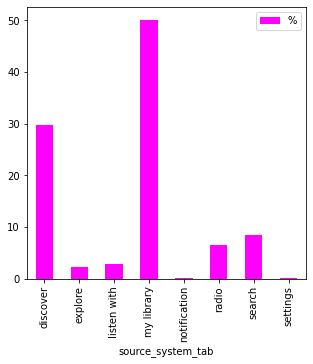

In [129]:
count = process_train_column('source_system_tab')
count

**Удалим строки с нулами их всего 25к:**

In [130]:
most_popular_system_tab = count.loc[count['count'].idxmax(), 'source_system_tab']
most_popular_system_tab

'my library'

**Source screen name**

source_screen_name
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nulls: 414804


,source_screen_name,count,%
0,Album more,420156,6.034458
1,Artist more,252429,3.625492
2,Concert,47,0.000675
3,Discover Chart,213658,3.068646
4,Discover Feature,244246,3.507964
5,Discover Genre,82202,1.180620
6,Discover New,15955,0.229152
7,Explore,72342,1.039006
8,Local playlist more,3228202,46.364799
9,My library,75980,1.091257


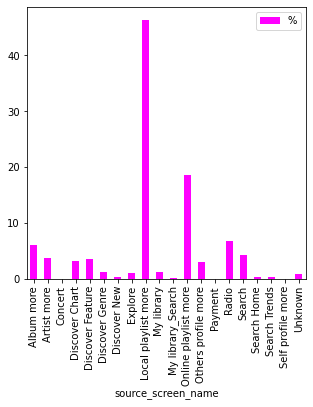

In [131]:
count = process_train_column('source_screen_name')
count

Удаляем строки с payment, concert, self profile more так для них очень мало данных.

In [132]:
most_popular_source_screen = count.loc[count['count'].idxmax(), 'source_screen_name']

mask = (train.source_screen_name != 'Payment') \
     & (train.source_screen_name != 'Concert') \
     & (train.source_screen_name != 'Self profile more')

train = train[mask]

most_popular_source_screen

'Local playlist more'

**Source type**

source_type
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nulls: 21539


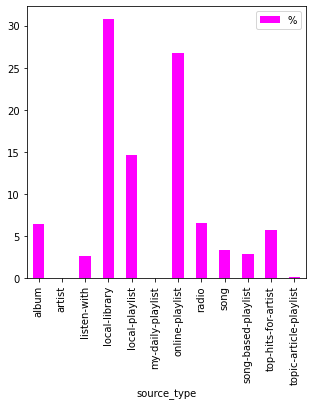

In [133]:
count = process_train_column('source_type')

**Удалим строки с нулами их всего 25к:**

In [134]:
most_popular_source_type = count.loc[count['count'].idxmax(), 'source_type']
most_popular_source_type

'local-library'

## Запуск CatBoost

**Train dtypes**

In [135]:
train.dtypes

user_id                            object
song_id                            object
source_system_tab                  object
source_screen_name                 object
source_type                        object
target                              uint8
city                                uint8
bd                                  int16
registration_year                   int64
registration_month                  int64
registration_day                    int64
expiration_year                     int64
expiration_month                    int64
expiration_day                      int64
subscription_length                 int32
subscription_level                  int64
registration_method                 int64
song_length                       float32
genre_ids                          object
artist_name                        object
language                          float64
song_registration_year            float64
song_country_code                  object
song_registration_organisation    

In [136]:
def warn_on(name):
    return 'Warning: {} not in columns'.format(name)

def to_type(frame, name, dtype):
    if name in frame.columns:
        frame.loc[:, name] = frame[name].astype(dtype)
    else:
        RuntimeWarning(warn_on(name))

def to_category(frame, names):
    for name in names:
        to_type(frame=frame, name=name, dtype='category')

In [164]:
cat_features = [ 
                # Sources
                'source_system_tab', 
                'source_screen_name',
                'source_type',

                # Members
                'city',
                'subscription_level',
                'registration_method',

                #Songs
                'genre_ids',
                'language',
                'artist_name',

                # Dates
                'registration_year',
                'registration_month',

                'expiration_year',
                'expiration_month',

                # Songs extra
                'song_registration_year',
                'song_country_code',
                'song_registration_organisation',
]

to_drop = [
           'song_id', 
           'target',
    
           # Dates -- если их оставить то они будут личить в test.
           'expiration_day',
           'registration_day',
]

to_int = {
    'language'               : np.uint8,
    'song_registration_year' : np.uint32
}

train.isnull().sum()

user_id                                0
song_id                                0
source_system_tab                  24849
source_screen_name                414804
source_type                        21539
target                                 0
city                                   0
bd                                     0
registration_year                      0
registration_month                     0
registration_day                       0
expiration_year                        0
expiration_month                       0
expiration_day                         0
subscription_length                    0
subscription_level                     0
registration_method                    0
song_length                         9251
genre_ids                           9251
artist_name                         9251
language                            9251
song_registration_year              1455
song_country_code                   1455
song_registration_organisation      1455
dtype: int64

Функция заполняющая пропуски наиболее популярным элементом из рассматриваемой категории

In [165]:
def fill_na(frame, name, value):
    """
    Fills columns in frame with specified value.
    """
    if name in frame.columns:
        frame.loc[:, name] = frame[name].fillna(value)
    else:
        warn_on_name(name)


def fill_na_(frame):
    """
    Fills NA with all known column mean values
    """
    # Songs
    fill_na(frame, 'artist_name', most_popular_artist)
    fill_na(frame, 'song_length', mean_song_length)
    fill_na(frame, 'genre_ids', most_popular_genre)
    fill_na(frame, 'language', most_popular_language)
    fill_na(frame, 'song_registration_year', most_common_year)
    fill_na(frame, 'song_country_code',  most_common_country_code)
    fill_na(frame, 'song_registration_organisation', most_common_reg_code)

    # Sources
    fill_na(frame, 'source_type', most_popular_source_type)
    fill_na(frame, 'source_system_tab', most_popular_system_tab)
    fill_na(frame, 'source_screen_name', most_popular_source_screen)
    

In [166]:
def add_biases(dataset):
    artists = dataset['artist_name']
    genres  = dataset['genre_ids']
    users   = dataset['user_id']

    def user_to_item(items, name):
        dataset['user_item'] = users.astype(str) + items.astype(str)
        item_counts   = dataset['user_item'].value_counts()
        dataset[name] = dataset['user_item'].apply(lambda item: item_counts[item])
        dataset.drop(['user_item'], axis=1, inplace=True)
        
    artist_name_counts      = artists.value_counts()
    dataset['artist_count'] = artists.apply(lambda a: artist_name_counts[a])
    user_to_item(genres,  'user_genres_counter')
    user_to_item(artists, 'user_artists_counter')     

Функция позволяющий обрабатывать датасет либо выбрасывая все нулы, либо заполняя их средними значениями:

In [167]:
def process_dataset(dataset, drop_na=False, to_drop=to_drop):
    print('start processing...')
    X_, y_ = None, None
    if drop_na:
        X_ = dataset.dropna()
        y_ = X_.target
    else:
        X_ = copy(dataset)
        y_ = X_.target
        fill_na_(X_)
      
    for name, dtype in to_int.items():
        X_.loc[:, name] = X_[name].astype(dtype)
     
    print('categorizing...')
    to_category(X_, cat_features)
    
    print('adding biases...')
    add_biases(X_)
    
    print('finished')
    
    return X_.drop(to_drop, axis=1), y_

Опишем нашу CatBoost модель:
так как у нас задача предсказания 0 / 1 то будет учить LogLoss.

In [141]:
def get_model(iterations=300):
    """
    Creates custom CatBoost model.
    
    Documentation for hyperpararms: https://catboost.ai/docs/concepts/speed-up-training.html
    """
    params = {
      'loss_function'              : 'Logloss',
      'custom_metric'              : 'AUC',
      'train_dir'                  : 'train_log',
      'max_ctr_complexity'         : 1, 
      'leaf_estimation_iterations' : 1,
      'learning_rate'              : 0.1,
      'iterations'                 : iterations    
    }
    return CatBoost(params=params)

In [142]:
def drop_user_id(X):
    return X.drop(['user_id'], axis=1)

def split_users(X, y, k):
    X['is_test'] = X['user_id'].apply(lambda x: hash(x) % 1000 < 1000 // k)
     
    test_mask  = X['is_test'] == True
    train_mask = X['is_test'] == False
    X.drop(['is_test'], axis=1, inplace=True)
    
    return drop_user_id(X[train_mask]), y[train_mask], drop_user_id(X[test_mask]), y[test_mask]

In [143]:
def k_fold_train(X, y, iterations=300, k=5):
    """
    returns: (aucs, models)
    """
    aucs, models = [], []    
    
    for i in range(k):
        print('Fold {} / {}'.format(i + 1, k))
        model = get_model(iterations=iterations)
        
        X_train, y_train, X__test, y__test = split_users(X, y, k)
        
        X__test, X_eval, y__test, y_eval = train_test_split(X__test, 
                                                            y__test, 
                                                            test_size=0.1,
                                                            shuffle=True)
        
        log_freq = iterations // 20 if iterations > 20 else 3
        
        model.fit(X_train, 
                  y_train,
                  cat_features=cat_features,
                  eval_set=(X_eval, y_eval),
                  metric_period=log_freq,
                  use_best_model=True,
                  verbose=True
                 )
        
        models.append(model)
    
        predicted = model.predict(X__test)
        auc = roc_auc_score(y__test, predicted)
        
        aucs.append(auc)
        print("AUC: {:07f}{}".format(auc, curve_sep))
        
    return aucs, models   

In [144]:
def train_random_sample(X, y, train_size, iterations=300, k=5):
    """
    returns: (aucs, models), x_test, y_test
    """
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        shuffle=True, 
                                                        train_size=train_size)
    
    return k_fold_train(X_train, y_train, iterations=iterations, k=k), Xtest, y_test

In [145]:
def train_ensemble(X, y, train_size, k=10, iterations=300):
    models = []
    for i in range(k):
        print('Model {} / {}'.format(i + 1, k))
        X_train, _, y_train, _ = train_test_split(X, y, shuffle=True, train_size=train_size)
        
        model = get_model(iterations)
        model.fit(X_train, y_train, cat_features=cat_features, verbose=True, metric_period=iterations // 10)
        models.append(model)
        
    return models    

**Shap values**

In [146]:
def explain_shap_values(X, y, model):
    _, X_test, _, _ = train_test_split(drop_user_id(X), y, test_size=0.2, shuffle=True)
    shap_values = shap.TreeExplainer(model).shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

**Протестируем нашу модель на двух датасетах, в одном все NA строки будут выкинуты, в другом заполнены либо средними либо наиболее повторяющимися значениями.**

Сначала протестируем на датасете в которым выкинуты все NA-value строки.

In [147]:
%%time
X_droped_na, y_droped_na = process_dataset(train, drop_na=True)

X_droped_na.shape

start processing...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


categorizing...
adding biases...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


finished
CPU times: user 1min 33s, sys: 25.9 s, total: 1min 59s
Wall time: 2min 11s


(6949045, 23)

In [148]:
X_droped_na.head()

,user_id,source_system_tab,source_screen_name,source_type,city,bd,registration_year,registration_month,expiration_year,expiration_month,...,song_length,genre_ids,artist_name,language,song_registration_year,song_country_code,song_registration_organisation,artist_count,user_genres_counter,user_artists_counter
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,Explore,online-playlist,1,0,2012,1,2017,10,...,206471.0,359,Bastille,54,2016,GB,02854,1079,162,3
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,Local playlist more,local-playlist,13,24,2011,5,2017,9,...,284584.0,1259,Various Artists,54,1999,US,10183,292987,47,24
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,Local playlist more,local-playlist,13,24,2011,5,2017,9,...,225396.0,1259,Nas,54,2006,US,18761,276,47,2
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,Local playlist more,local-playlist,13,24,2011,5,2017,9,...,255512.0,1019,Soundway,1,2010,GB,00063,1,1,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,Explore,online-playlist,1,0,2012,1,2017,10,...,187802.0,1011,Brett Young,54,2016,QM,06003,415,38,1


In [149]:
%%time
aucs, models = k_fold_train(X=X_droped_na, 
                            y=y_droped_na,
                            iterations=400)

Fold 1 / 5
0:	learn: 0.6844437	test: 0.6843843	best: 0.6843843 (0)	total: 3.92s	remaining: 26m 6s
20:	learn: 0.6357822	test: 0.6355994	best: 0.6355994 (20)	total: 42s	remaining: 12m 38s
40:	learn: 0.6284037	test: 0.6288735	best: 0.6288735 (40)	total: 1m 16s	remaining: 11m 11s
60:	learn: 0.6253123	test: 0.6264609	best: 0.6264609 (60)	total: 1m 50s	remaining: 10m 14s
80:	learn: 0.6233355	test: 0.6250548	best: 0.6250548 (80)	total: 2m 25s	remaining: 9m 31s
100:	learn: 0.6219917	test: 0.6241548	best: 0.6241548 (100)	total: 2m 58s	remaining: 8m 49s
120:	learn: 0.6206936	test: 0.6231222	best: 0.6231222 (120)	total: 3m 35s	remaining: 8m 16s
140:	learn: 0.6197782	test: 0.6225117	best: 0.6225117 (140)	total: 4m 9s	remaining: 7m 37s
160:	learn: 0.6188510	test: 0.6220980	best: 0.6220980 (160)	total: 4m 43s	remaining: 7m 1s
180:	learn: 0.6180629	test: 0.6217011	best: 0.6217011 (180)	total: 5m 17s	remaining: 6m 24s
200:	learn: 0.6172657	test: 0.6213681	best: 0.6213681 (200)	total: 5m 51s	remaining:

40:	learn: 0.6284037	test: 0.6298939	best: 0.6298939 (40)	total: 1m 15s	remaining: 11m 3s
60:	learn: 0.6253123	test: 0.6275341	best: 0.6275341 (60)	total: 1m 49s	remaining: 10m 10s
80:	learn: 0.6233355	test: 0.6261956	best: 0.6261956 (80)	total: 2m 23s	remaining: 9m 24s
100:	learn: 0.6219917	test: 0.6253323	best: 0.6253323 (100)	total: 2m 57s	remaining: 8m 44s
120:	learn: 0.6206936	test: 0.6243545	best: 0.6243545 (120)	total: 3m 30s	remaining: 8m 6s
140:	learn: 0.6197782	test: 0.6237200	best: 0.6237200 (140)	total: 4m 4s	remaining: 7m 29s
160:	learn: 0.6188510	test: 0.6232822	best: 0.6232822 (160)	total: 4m 38s	remaining: 6m 53s
180:	learn: 0.6180629	test: 0.6228715	best: 0.6228715 (180)	total: 5m 13s	remaining: 6m 19s
200:	learn: 0.6172657	test: 0.6225832	best: 0.6225832 (200)	total: 5m 47s	remaining: 5m 43s
220:	learn: 0.6165232	test: 0.6223516	best: 0.6223516 (220)	total: 6m 20s	remaining: 5m 8s
240:	learn: 0.6159549	test: 0.6221176	best: 0.6221176 (240)	total: 6m 54s	remaining: 4m 

In [150]:
aucs

[0.7120967477668338,
 0.7122964981961148,
 0.712094995595175,
 0.7122918319391013,
 0.7122466014621558]

SHAP values explanation for droped NA dataset

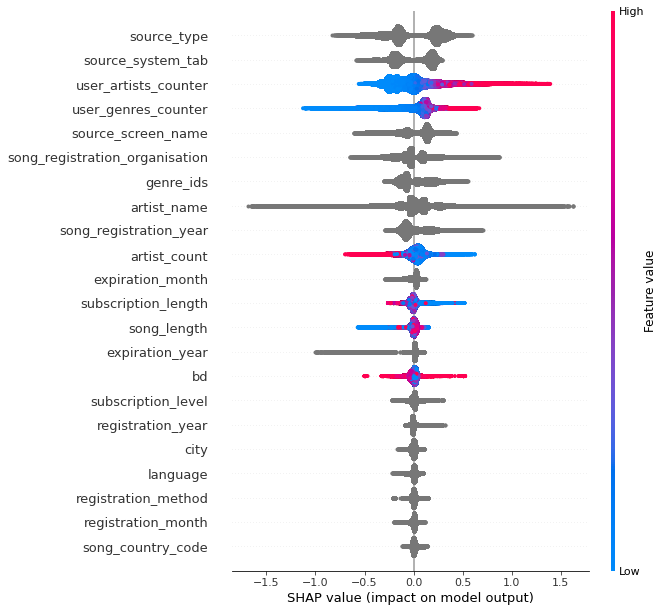

In [151]:
%%time
explain_shap_values(X_droped_na, y_droped_na, models[0])

**Натренируем модель на датасете в котором все NA-value были заменены на "среднее по больнице" (c) Евгений Малютин**

In [152]:
%%time
X_filled_na, y_filled_na = process_dataset(train, drop_na=False)
X_filled_na.shape

CPU times: user 7min 58s, sys: 7.3 s, total: 8min 5s
Wall time: 3min 45s
start processing...
categorizing...
adding biases...
finished
CPU times: user 1min 36s, sys: 31.1 s, total: 2min 8s
Wall time: 2min 21s


(7377147, 23)

In [153]:
X_filled_na.head()

,user_id,source_system_tab,source_screen_name,source_type,city,bd,registration_year,registration_month,expiration_year,expiration_month,...,song_length,genre_ids,artist_name,language,song_registration_year,song_country_code,song_registration_organisation,artist_count,user_genres_counter,user_artists_counter
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,Explore,online-playlist,1,0,2012,1,2017,10,...,206471.0,359,Bastille,54,2016,GB,02854,1140,166,3
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,Local playlist more,local-playlist,13,24,2011,5,2017,9,...,284584.0,1259,Various Artists,54,1999,US,10183,303342,47,24
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,Local playlist more,local-playlist,13,24,2011,5,2017,9,...,225396.0,1259,Nas,54,2006,US,18761,289,47,2
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,Local playlist more,local-playlist,13,24,2011,5,2017,9,...,255512.0,1019,Soundway,1,2010,GB,00063,1,1,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,Explore,online-playlist,1,0,2012,1,2017,10,...,187802.0,1011,Brett Young,54,2016,QM,06003,427,38,1


In [154]:
%%time
aucs, models = k_fold_train(X=X_filled_na, 
                            y=y_filled_na, 
                            iterations=400)

Fold 1 / 5
0:	learn: 0.6845552	test: 0.6844863	best: 0.6844863 (0)	total: 4.85s	remaining: 32m 15s
20:	learn: 0.6370153	test: 0.6369113	best: 0.6369113 (20)	total: 43.6s	remaining: 13m 6s
40:	learn: 0.6293431	test: 0.6297828	best: 0.6297828 (40)	total: 1m 19s	remaining: 11m 37s
60:	learn: 0.6264261	test: 0.6274406	best: 0.6274406 (60)	total: 1m 57s	remaining: 10m 51s
80:	learn: 0.6242726	test: 0.6257417	best: 0.6257417 (80)	total: 2m 34s	remaining: 10m 7s
100:	learn: 0.6226493	test: 0.6245882	best: 0.6245882 (100)	total: 3m 10s	remaining: 9m 23s
120:	learn: 0.6213714	test: 0.6237911	best: 0.6237911 (120)	total: 3m 47s	remaining: 8m 43s
140:	learn: 0.6202334	test: 0.6230858	best: 0.6230858 (140)	total: 4m 23s	remaining: 8m 3s
160:	learn: 0.6192694	test: 0.6224796	best: 0.6224796 (160)	total: 4m 58s	remaining: 7m 23s
180:	learn: 0.6184522	test: 0.6220064	best: 0.6220064 (180)	total: 5m 34s	remaining: 6m 45s
200:	learn: 0.6176556	test: 0.6216483	best: 0.6216483 (200)	total: 6m 11s	remaini

40:	learn: 0.6293431	test: 0.6291322	best: 0.6291322 (40)	total: 1m 20s	remaining: 11m 46s
60:	learn: 0.6264261	test: 0.6267648	best: 0.6267648 (60)	total: 1m 56s	remaining: 10m 48s
80:	learn: 0.6242726	test: 0.6251166	best: 0.6251166 (80)	total: 2m 32s	remaining: 10m 1s
100:	learn: 0.6226493	test: 0.6240116	best: 0.6240116 (100)	total: 3m 8s	remaining: 9m 19s
120:	learn: 0.6213714	test: 0.6232286	best: 0.6232286 (120)	total: 3m 44s	remaining: 8m 38s
140:	learn: 0.6202334	test: 0.6225686	best: 0.6225686 (140)	total: 4m 20s	remaining: 7m 58s
160:	learn: 0.6192694	test: 0.6219339	best: 0.6219339 (160)	total: 4m 56s	remaining: 7m 20s
180:	learn: 0.6184522	test: 0.6214763	best: 0.6214763 (180)	total: 5m 32s	remaining: 6m 42s
200:	learn: 0.6176556	test: 0.6211267	best: 0.6211267 (200)	total: 6m 8s	remaining: 6m 4s
220:	learn: 0.6170021	test: 0.6208728	best: 0.6208728 (220)	total: 6m 44s	remaining: 5m 27s
240:	learn: 0.6163740	test: 0.6207022	best: 0.6207022 (240)	total: 7m 20s	remaining: 4m

In [155]:
aucs

[0.7119950300518444,
 0.7120977396362845,
 0.7120958254921211,
 0.7117545902678906,
 0.7119235316468829]

**SHAP values explanation for filled NA dataset**

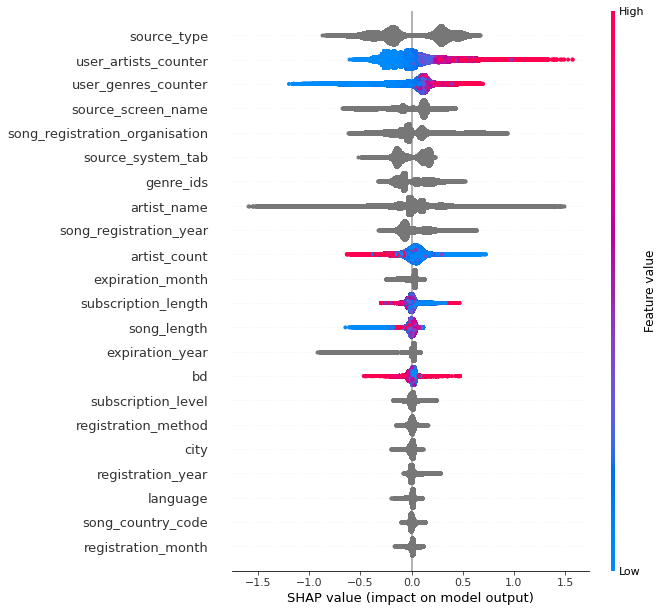

CPU times: user 8min 25s, sys: 7.23 s, total: 8min 33s
Wall time: 3min 58s


In [156]:
%%time
explain_shap_values(X_filled_na, y_filled_na, models[0])

**Save droped NA train dataset**

In [168]:
%%time
X_, _ = process_dataset(train, drop_na=True, to_drop=['expiration_day', 'registration_day'])
X_.head()

start processing...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


categorizing...
adding biases...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


finished
CPU times: user 1min 37s, sys: 30.8 s, total: 2min 8s
Wall time: 2min 23s


,user_id,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registration_year,registration_month,...,song_length,genre_ids,artist_name,language,song_registration_year,song_country_code,song_registration_organisation,artist_count,user_genres_counter,user_artists_counter
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,2012,1,...,206471.0,359,Bastille,54,2016,GB,02854,1079,162,3
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,2011,5,...,284584.0,1259,Various Artists,54,1999,US,10183,292987,47,24
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,2011,5,...,225396.0,1259,Nas,54,2006,US,18761,276,47,2
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,2011,5,...,255512.0,1019,Soundway,1,2010,GB,00063,1,1,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,2012,1,...,187802.0,1011,Brett Young,54,2016,QM,06003,415,38,1


In [169]:
%%time
X_.to_csv('data/train_processed.csv', index=False)

CPU times: user 1min 13s, sys: 3.07 s, total: 1min 16s
Wall time: 1min 20s


#### Kaggle part

In [158]:
test['target'] = 0
test_filled, _ = process_dataset(test)

start processing...
categorizing...
adding biases...
finished


In [159]:
%%time
predictions = [m.predict(test_filled.drop(['id', 'user_id'], axis=1), prediction_type='Probability')[:, 1] for m in models]
predictions = np.array(predictions)

CPU times: user 41.2 s, sys: 1.05 s, total: 42.3 s
Wall time: 27.7 s


In [160]:
submission = pd.DataFrame({ 'id': test.id, 'target': predictions.mean(axis=0) })
submission.head()

,id,target
0,0,0.486963
1,1,0.551272
2,2,0.120482
3,3,0.124779
4,4,0.089637


In [161]:
submission.to_csv('submission.csv', index=False)

In [162]:
# Kaggle AUC ~ 0.69